# PyTorch Custom Datasets

We've used some datasets with PyTorch, but how do you get your own data into PyTorch?

One of the ways you can do this is with custom datasets.

Depending on what you're working on, text, vision, audio, you'll want to look at the existing PyTorch domain libraries for customizable data loading functions.

## Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn
torch.__version__


'2.4.1+cu121'

In [2]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get Data

Our dataset is a subset of the Food101 dataset.  It starts with 3 classes of food, and only 10% of the images (1000 images per class, 750 training, 250 testing).

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak, sushi data...


## Becoming one with the data (data preparation and data exploration)

In [4]:
import os

def walk_through_dir(dir_path):
  """ Walks through dir_path returning it's contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi
There are 3 directories and 0 images in 'data/pizza_steak_sushi
There are 0 directories and 78 images in 'data/pizza_steak_sushi
There are 0 directories and 72 images in 'data/pizza_steak_sushi
There are 0 directories and 75 images in 'data/pizza_steak_sushi
There are 3 directories and 0 images in 'data/pizza_steak_sushi
There are 0 directories and 25 images in 'data/pizza_steak_sushi
There are 0 directories and 31 images in 'data/pizza_steak_sushi
There are 0 directories and 19 images in 'data/pizza_steak_sushi


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing an image

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem()`
4. Since we're working with images, let's open the image using PIL
5. We'll then show the image and print metadata

data/pizza_steak_sushi/train/pizza/2800325.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/2800325.jpg
Image class: pizza
Image height: 512
Image width: 512
Image mode: RGB
Image format: JPEG (ISO 10918)


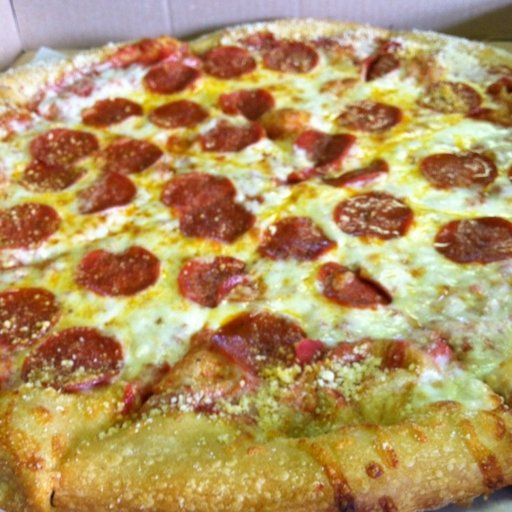

In [6]:
import random
from PIL import Image

# Set the seed
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from the path name (the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image mode: {img.mode}")
print(f"Image format: {img.format_description}")
img

(512, 512, 3)


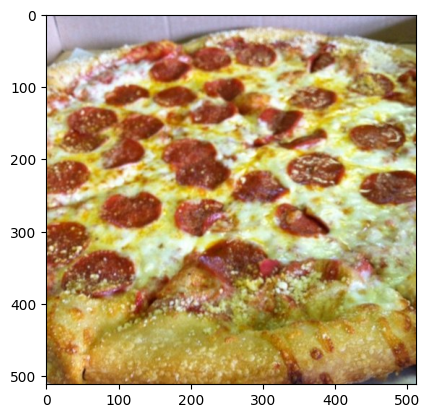

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an arrya
img_as_array = np.asarray(img)
print(img_as_array.shape)

# Plot the image
plt.imshow(img_as_array)


In [8]:
img_as_array.shape

(512, 512, 3)

## Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently `torch.utils.data.DataLoader`


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a Torch Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.4118, 0.4745, 0.5294,  ..., 0.7529, 0.7333, 0.8510],
         [0.3137, 0.3373, 0.3843,  ..., 0.7608, 0.7765, 0.8627],
         [0.3059, 0.3098, 0.3137,  ..., 0.7765, 0.8275, 0.8627],
         ...,
         [0.1725, 0.2275, 0.3176,  ..., 0.4941, 0.4824, 0.5529],
         [0.3569, 0.3176, 0.3098,  ..., 0.5137, 0.5098, 0.5529],
         [0.5804, 0.5490, 0.4667,  ..., 0.5216, 0.5255, 0.5373]],

        [[0.3882, 0.4471, 0.5059,  ..., 0.7176, 0.6980, 0.8196],
         [0.2706, 0.2980, 0.3451,  ..., 0.7255, 0.7412, 0.8314],
         [0.2549, 0.2588, 0.2627,  ..., 0.7373, 0.7961, 0.8314],
         ...,
         [0.1451, 0.1765, 0.2118,  ..., 0.3333, 0.3529, 0.4667],
         [0.3647, 0.3255, 0.2941,  ..., 0.3765, 0.3765, 0.4275],
         [0.6431, 0.5961, 0.5020,  ..., 0.3686, 0.3647, 0.4039]],

        [[0.3804, 0.4745, 0.5569,  ..., 0.8039, 0.7922, 0.9098],
         [0.1725, 0.2157, 0.2941,  ..., 0.8078, 0.8314, 0.9137],
         [0.1451, 0.1451, 0.1451,  ..., 0.8275, 0.8863, 0.

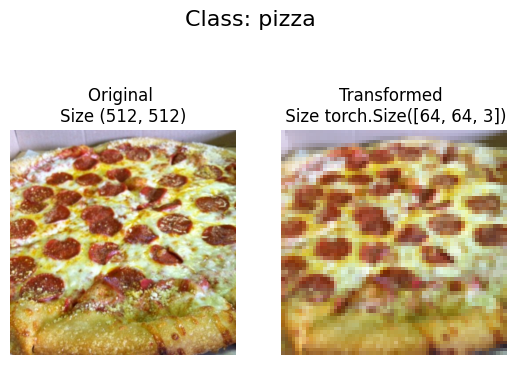

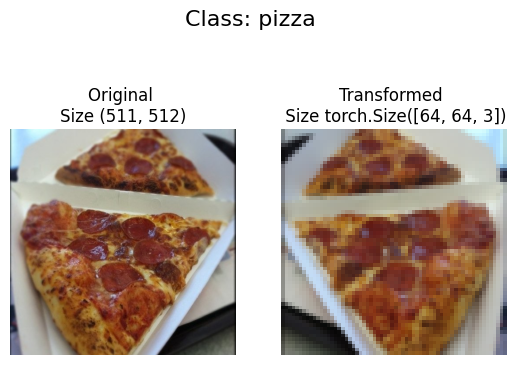

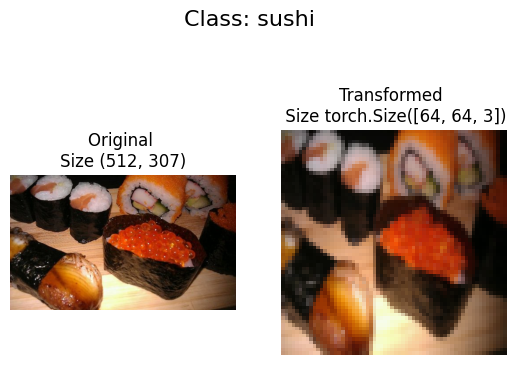

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and plots them.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


## Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`



In [13]:
# Use ImageFolder to load the images
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform =data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
train_data.classes

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of the dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [18]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [19]:
label

0

In [20]:
class_names =  train_data.classes
class_names[label]

'pizza'

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img_permute

tensor([[[0.1137, 0.0745, 0.0941],
         [0.1020, 0.0706, 0.0902],
         [0.0980, 0.0745, 0.0902],
         ...,
         [0.1255, 0.0588, 0.0157],
         [0.1216, 0.0588, 0.0196],
         [0.1176, 0.0588, 0.0196]],

        [[0.1059, 0.0745, 0.0902],
         [0.0980, 0.0706, 0.0863],
         [0.0980, 0.0745, 0.0902],
         ...,
         [0.1294, 0.0627, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196]],

        [[0.1020, 0.0706, 0.0902],
         [0.0980, 0.0745, 0.0902],
         [0.0941, 0.0745, 0.0902],
         ...,
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0196]],

        ...,

        [[0.1098, 0.1255, 0.1294],
         [0.1098, 0.1333, 0.1333],
         [0.1255, 0.1373, 0.1490],
         ...,
         [0.1686, 0.2510, 0.1961],
         [0.1647, 0.2392, 0.1882],
         [0.1686, 0.2392, 0.1843]],

        [[0.0902, 0.1098, 0.1098],
         [0.0941, 0.1176, 0.1137],
         [0.

Text(0.5, 1.0, 'pizza')

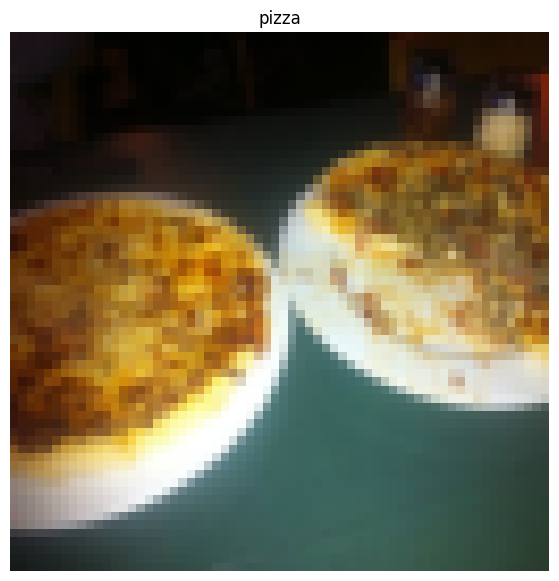

In [22]:
# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label])

### Turn loaded images into `DataLoader`

A `DataLoader` is going to help us batch our data and turn it into an iterable

In [23]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [24]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7da888586320>,
 <torch.utils.data.dataloader.DataLoader at 0x7da888586200>)

In [25]:
img, label = next(iter(train_dataloader))
print(f"Image shape {img.shape}")
print(f"Label shape {label.shape}")

Image shape torch.Size([1, 3, 64, 64])
Label shape torch.Size([1])


## Option 2: Loading image data with a custom dataset

1. Want to load images from file
2. Want to get class names as a list
3. Want to get classes as a dictionary

Pros:
* Can create a `Dataset` out of almost anything
* NOt limited to PyTorch pre-built dataset functions

Cons:
* Even though you could create a datset out of almost anything, it doesn't mean it will work..
* Using a custom `Dataset` often results in writing more code, which could be prone to errors and performance issues

In [26]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory that is in standard image classification format
2. Raise an error if the class names are not found
3. Turn the class names into a dict, and a list, and return them

In [28]:
# Setup path for target directory
target_directory = train_dir
target_directory

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  # Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as a transform
3. Create several attributes:
  * paths - the paths of our images
  * transform = the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this will open an image
5. Override the `__len__` function as suggested
6. Override the `__get__` method to return a given sample when passed an index

In [31]:
# Write a custom dataset
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    """Opens and image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label(target)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [32]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7da7b4f8c5b0>,
 <__main__.ImageFolderCustom at 0x7da7b4f8f460>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# Check for equality between original image folder dataset, and image folder custom dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### Create a function to display random images

In [39]:
# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust the display if n is too high
  if n > 10:
    n = 10
    display_shape = False

  # Set the random seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    plt.subplot(1, n, i+1)
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\n, shape: {targ_image.shape}"
    plt.title(title)


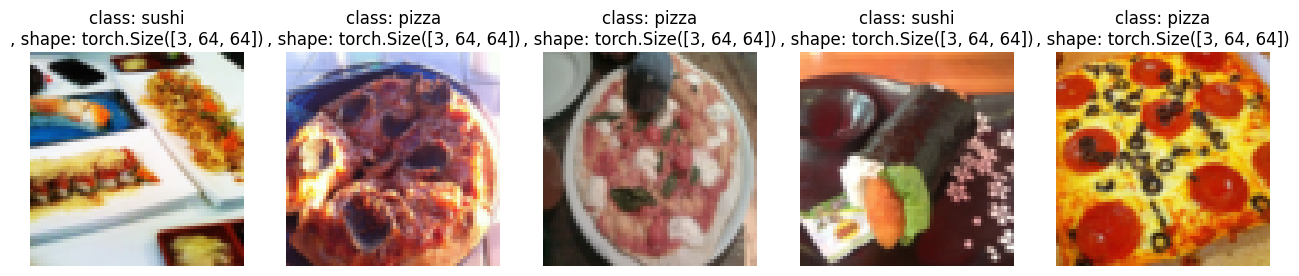

In [40]:
# Display random images from ImageFolder created dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

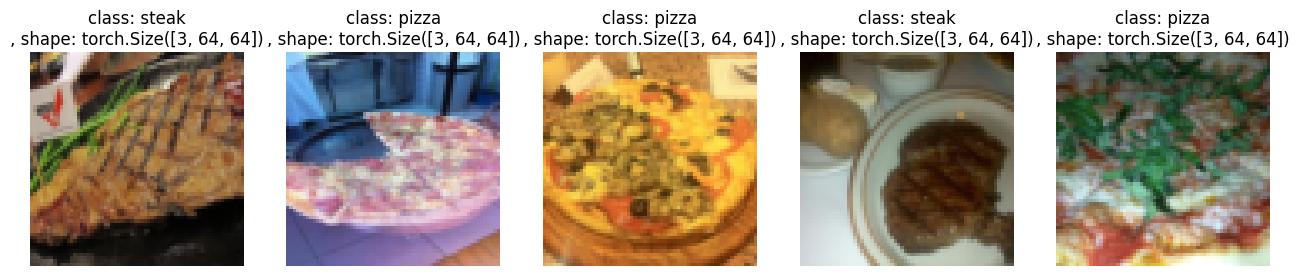

In [41]:
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### Turn custom loaded images into DataLoader

In [42]:
from torch.utils.data import dataloader
import os
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count())

In [43]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7da7b32005e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7da7b3202680>)

In [44]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In image data, this may mean applying various image transformations.

We're going to look at a transformation that is used to train torch vision models to state of the art levels.  [More information here](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [45]:
# Let's look at TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [46]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/1105700.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1947572.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3196721.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1572608.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2992084.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2228322.jpg')]

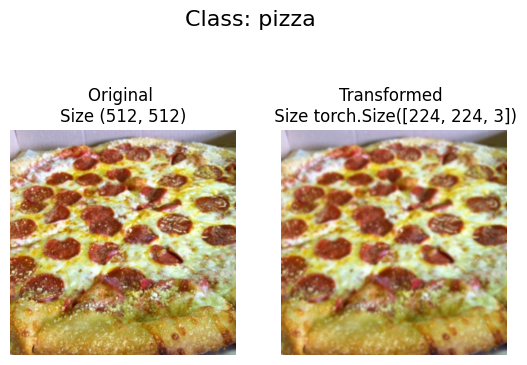

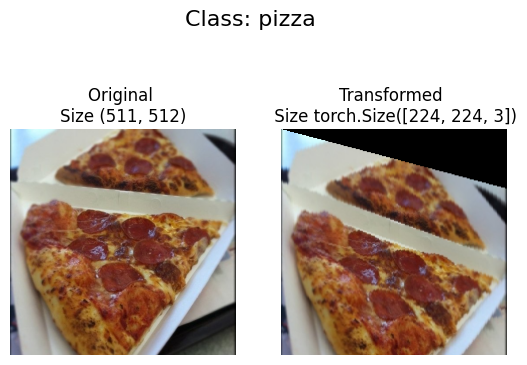

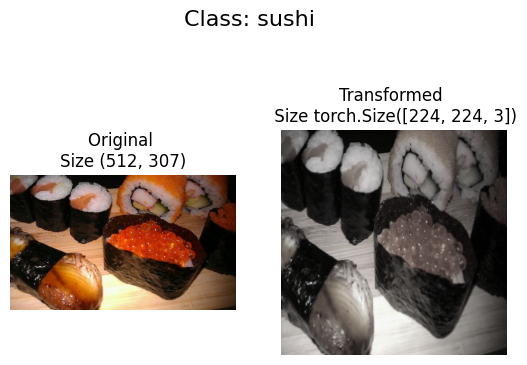

In [47]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=42
)

## Model 0 TinyVGG without data augmentation.

In [50]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [51]:
# Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [52]:
# Turn the datsets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)


In [60]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Benefits from operator fusion

In [61]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # Number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image

In [62]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [63]:
# Try a forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` to get an idea of the shapes of our model

In [64]:
!pip install torchinfo

In [65]:
from torchinfo import summary

In [79]:
summary(model_0, input_size=(1, 3, 64, 64), verbose=1)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create train and test loop functions

* `train_step()` takes in a model and dataloader and trains the model
* `test_step()` takes in a model and a dataloader and evaluates the model

In [81]:
# Create the train_step function

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    model.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate the accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get the avg. loss per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [82]:
# Create a test step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      model.to(device)

      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

In [83]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  results = {"train loss": [],
             "train acc": [],
             "test loss": [],
             "test acc": []}

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train loss"].append(train_loss)
    results["train acc"].append(train_acc)
    results["test loss"].append(test_loss)
    results["test acc"].append(test_acc)

  return results

In [86]:
from timeit import default_timer as timer

torch.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Total training time: 8.814 seconds


### Plot the loss curves of model_0

In [87]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train loss', 'train acc', 'test loss', 'test acc'])

In [88]:
def plot_loss_curves(results: Dict[str, list[float]]):
  """Plots training curves of a results dictionary"""

  loss = results["train loss"]
  test_loss = results["test loss"]

  accuracy = results["train acc"]
  test_accuracy = results["test acc"]

  epochs = range(len(results["train loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train loss")
  plt.plot(epochs, test_loss, label="test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train accuracy")
  plt.plot(epochs, test_accuracy, label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

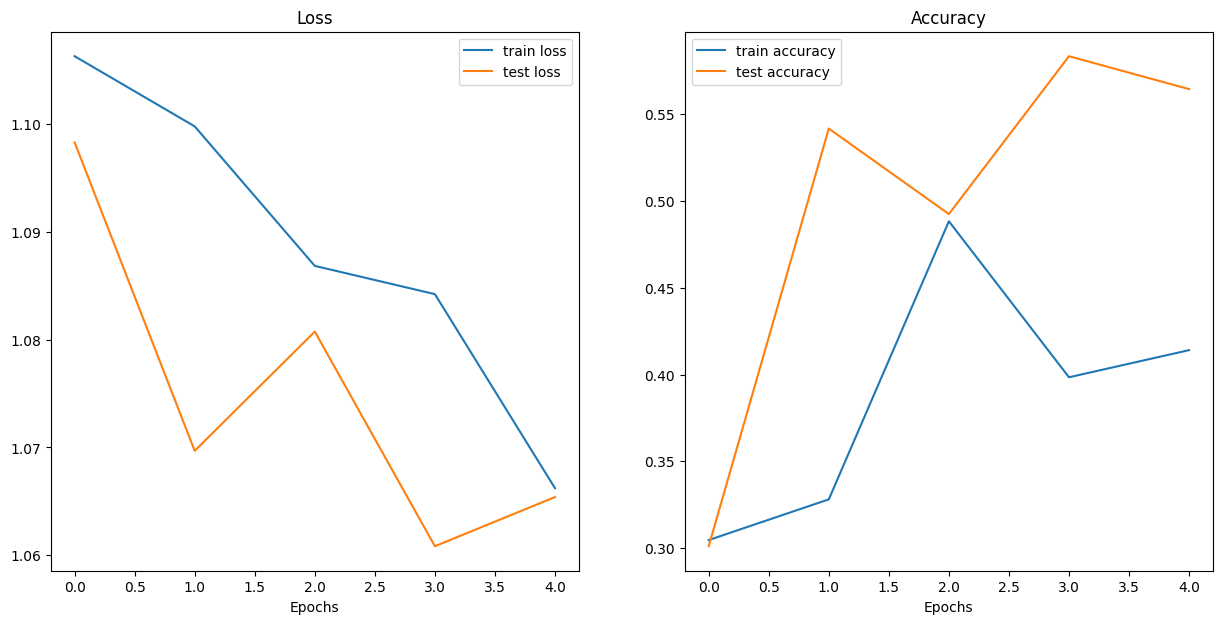

In [90]:
plot_loss_curves(model_0_results)

## Model 1 TinyVGG with Data Augmentation

We're going to try a model using the same model as before but with some data augmentation

### Create a transform with data augmentation

In [93]:
# Create a training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create a test transform
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [96]:
# Turn image folders into datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform_simple)

In [97]:
# Turn datasets into DataLoaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### Construct and train model 1 using augmented data

In [98]:
# Create model_1

torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

In [99]:
torch.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1253 | Train acc: 0.3047 | Test loss: 1.1581 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0865 | Train acc: 0.4258 | Test loss: 1.1554 | Test acc: 0.3333
Total training time: 10.646 seconds


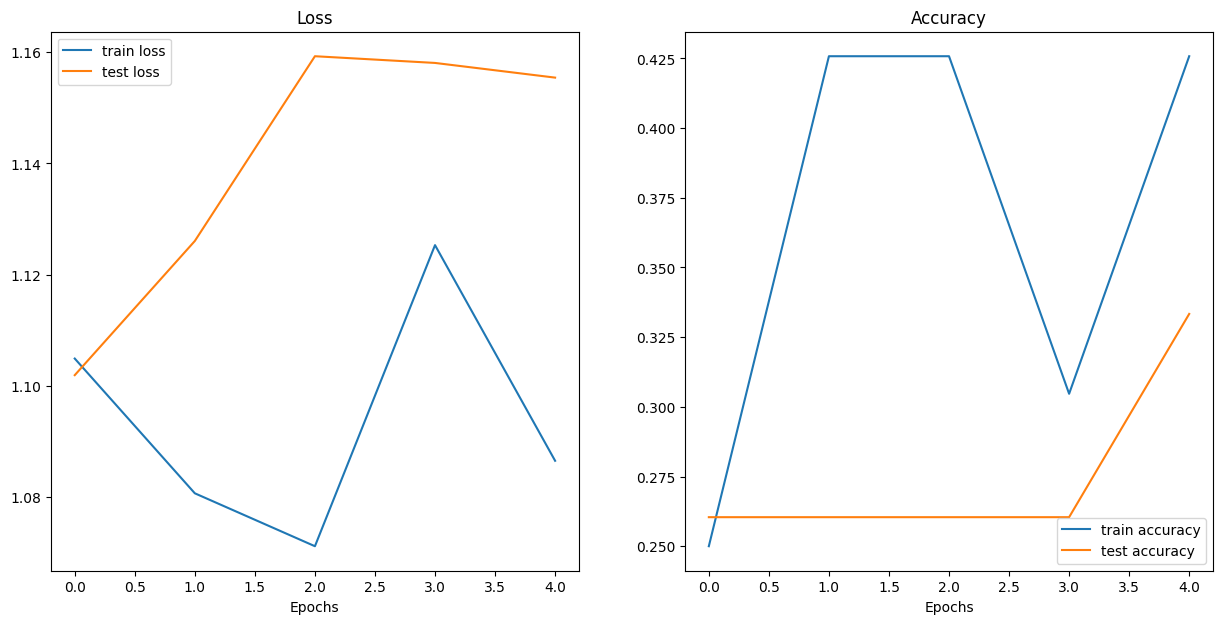

In [100]:
plot_loss_curves(model_1_results)

## Compare model results

After evaluating out modelling experiments on their own, it's import to compare them to each other.

We can do this by
1. Hard coding
2. PyTorch + TensorBoard
3. Weights & Biases https://wandb.ai/site
4. MLFlow https://mlflow.org/

In [103]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train loss,train acc,test loss,test acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


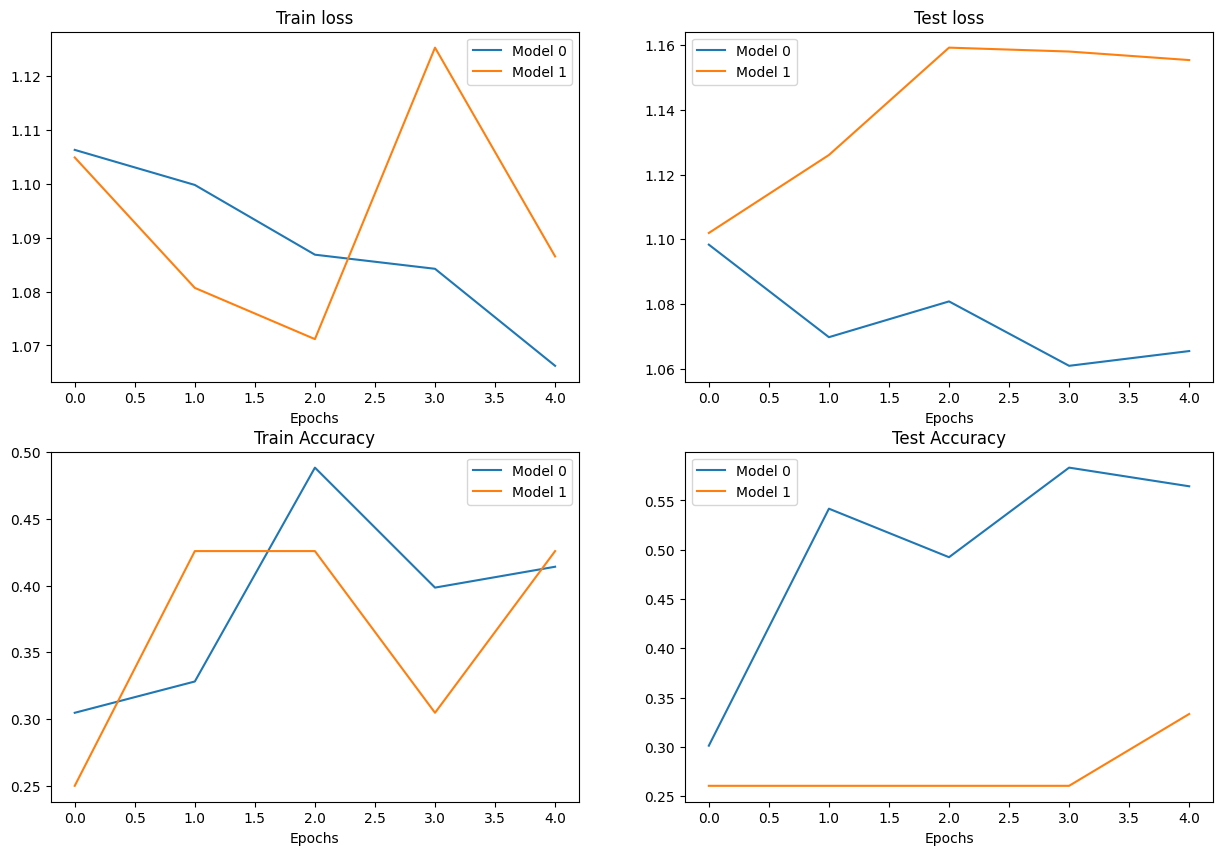

In [110]:
# Setup a plot
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train loss"], label="Model 0")
plt.plot(epochs, model_1_df["train loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test loss"], label="Model 0")
plt.plot(epochs, model_1_df["test loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train acc"], label="Model 0")
plt.plot(epochs, model_1_df["train acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot the train accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test acc"], label="Model 0")
plt.plot(epochs, model_1_df["test acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

Making a prediction on a custom image

Although the models are trained, poorly, how do you make a prediction on something that's not within your dataset.

This is to just see what the workflow would be like

In [121]:
# Download custom image (THIS IS BROKEN CANNOT RETRIEVE RAW FILE)
import requests
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/6aa8b4c9f868c6fc6113badce81b38cda71dfd30/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")


In [122]:
import torchvision
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

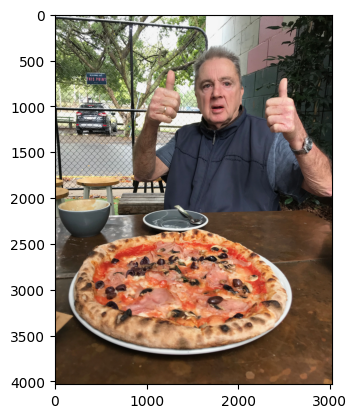

In [123]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [129]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [126]:
# Convert the custom image to torch.float32
custom_image = custom_image_uint8.type(torch.float32)
custom_image.shape

torch.Size([3, 4032, 3024])

In [132]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [133]:
custom_image = custom_image / 255.0
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [136]:
# Create a transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [137]:
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [138]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))
custom_image_pred

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [139]:
# We need to add a batch size
custom_image_batch = custom_image_transformed.unsqueeze(dim=0)
custom_image_batch.shape

torch.Size([1, 3, 64, 64])

In [140]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_batch.to(device))
custom_image_pred

tensor([[ 0.0780,  0.0379, -0.2067]])

In [141]:
class_names

['pizza', 'steak', 'sushi']

### Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model
* Make sure the image was the same shape the model was trained on..including batch size
*Make sure the image was sure on the same device

In [142]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [145]:
# Convert prediction probabilities to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [146]:
class_names[custom_image_pred_label]

'pizza'

### Putting custom image prediction together: building a function

Ideal outcome:

A funtion where we pass an image path and have our model predict the class of the image

In [147]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str]=None,
                        transform=None,
                        device=device):
  """ Makes a prediction on a target image with a trained model and plots the image."""

  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide image values by 255 to get them between 0 and 1
  target_image = target_image / 255.0

  # Transform our data if necessary
  if transform:
    target_image = transform(target_image)

  # Add an extra dimension to the image for the batch
  target_image = target_image.unsqueeze(dim=0)

  # Turn the target image to a prediction
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred = model(target_image.to(device))

  # Convert the prediction probabilities to prediction labels
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongsize the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # Remove batch dimension, and rearrange shape of image
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu()} "
  plt.title(title)
  plt.axis(False)




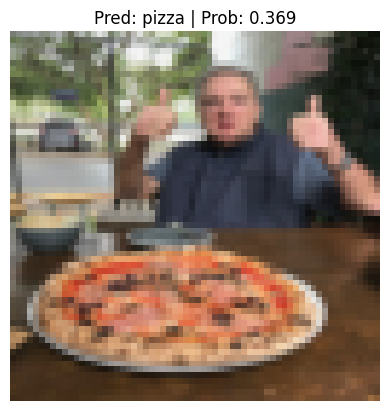

In [148]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)